In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib
import numpy as np
import xgboost as xgb
import pandas as pd
import shap
import pickle
import matplotlib.pyplot as plt
import itertools

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from datetime import datetime

In [3]:
with open('./data/obj', 'rb') as file:
    data = pickle.load(file)
clf = data[0]
df = data[1].dropna().reset_index().drop('index', axis=1)

[15:42:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [16]:
def create_variable_list_new(min_val, max_val):
    delta = (max_val - min_val) / 10
    col_vals = []
    while min_val <= max_val:
        col_vals.append(min_val)
        min_val += delta
    return col_vals

category = {x: df[x].unique() for x in find_category_columns(df)}
numeric = getMinMax(df.drop(category.keys(), axis=1))
numeric = {key: create_variable_list_new(value[0], value[1])  for key, value in numeric.items()}
numeric.update(category)
numeric

{'Age': [0.42,
  8.378,
  16.336,
  24.293999999999997,
  32.251999999999995,
  40.209999999999994,
  48.16799999999999,
  56.12599999999999,
  64.08399999999999,
  72.04199999999999,
  79.99999999999999],
 'Fare': [0.0,
  51.23292,
  102.46584,
  153.69876,
  204.93168,
  256.1646,
  307.39752,
  358.63043999999996,
  409.86335999999994,
  461.0962799999999,
  512.3291999999999],
 'Pclass': array([3, 1, 2], dtype=int64),
 'Sex': array([0, 1]),
 'SibSp': array([1, 0, 3, 4, 2, 5], dtype=int64),
 'Parch': array([0, 1, 2, 5, 3, 4, 6], dtype=int64),
 'Cabin': array([8, 2, 4, 6, 3, 0, 1, 5, 7]),
 'Embarked': array([2, 0, 1, 3])}

In [17]:
from more_itertools import nth_product

In [18]:
len(numeric['Fare'])

11

In [20]:
df_raw = itertools.product(*numeric.values())

In [19]:
from shap.explainers import GPUTree

In [25]:
from shap.explainers import TreeExplainer

ImportError: cannot import name 'TreeExplainer' from 'shap.explainers' (D:\MIA\venv\Lib\site-packages\shap\explainers\__init__.py)

In [26]:
def test_perf_gpu(x):
    start = datetime.now()
    numeric['Age'] = list(range(0, 100, x))
    df_raw = itertools.product(*numeric.values())
    columns = numeric.keys()
    types = {key: type(value[0]) for key, value in numeric.items()}
    test_df = pd.DataFrame(data=df_raw, columns=columns)
    test_df = test_df.astype(types)
    time_1 = datetime.now() - start
    start = datetime.now()
    
    explainer = GPUTree(clf)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(test_df.copy())
    time_2 = datetime.now() - start
    start = datetime.now()
    col_names = []
    indexes = []
    mean_importance = list(np.mean(np.absolute(shap_values), axis=0))
    max_list = sorted(mean_importance)[-5:]
    for max_val in max_list:
        indexes.append(mean_importance.index(max_val))
        col_names.append(test_df.columns[mean_importance.index(max_val)])
    time_3 = datetime.now() - start
    print(f"Число строк {test_df['Age'].count()}. Время генерации датасета {time_1}. Время расчёта значений Шепли {time_2}. Время расчёта параметров {time_3}")

In [27]:
from tqdm import tqdm

In [28]:
for x in tqdm(range(10, 0, -1)):
    test_perf_gpu(x)

 10%|███████████████████▌                                                                                                                                                                               | 1/10 [00:42<06:20, 42.23s/it]

Число строк 997920. Время генерации датасета 0:00:21.180287. Время расчёта значений Шепли 0:00:21.000310. Время расчёта параметров 0:00:00.035057


 20%|███████████████████████████████████████                                                                                                                                                            | 2/10 [01:33<06:18, 47.29s/it]

Число строк 1197504. Время генерации датасета 0:00:25.466833. Время расчёта значений Шепли 0:00:25.311466. Время расчёта параметров 0:00:00.047912


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                        | 3/10 [02:27<05:53, 50.57s/it]

Число строк 1297296. Время генерации датасета 0:00:27.565497. Время расчёта значений Шепли 0:00:26.853392. Время расчёта параметров 0:00:00.047266


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                     | 4/10 [03:30<05:32, 55.50s/it]

Число строк 1496880. Время генерации датасета 0:00:31.809328. Время расчёта значений Шепли 0:00:31.181622. Время расчёта параметров 0:00:00.054196


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 5/10 [04:43<05:09, 61.87s/it]

Число строк 1696464. Время генерации датасета 0:00:36.074178. Время расчёта значений Шепли 0:00:37.036756. Время расчёта параметров 0:00:00.044019


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 6/10 [06:08<04:38, 69.72s/it]

Число строк 1995840. Время генерации датасета 0:00:42.611595. Время расчёта значений Шепли 0:00:42.273173. Время расчёта параметров 0:00:00.053012


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 7/10 [07:54<04:04, 81.43s/it]

Число строк 2494800. Время генерации датасета 0:00:53.222855. Время расчёта значений Шепли 0:00:52.229511. Время расчёта параметров 0:00:00.060240


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8/10 [10:17<03:22, 101.20s/it]

Число строк 3392928. Время генерации датасета 0:01:11.873102. Время расчёта значений Шепли 0:01:11.569413. Время расчёта параметров 0:00:00.070167


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 9/10 [13:57<02:18, 138.31s/it]

Число строк 4989600. Время генерации датасета 0:01:47.158584. Время расчёта значений Шепли 0:01:52.598845. Время расчёта параметров 0:00:00.119018


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [21:03<00:00, 126.33s/it]

Число строк 9979200. Время генерации датасета 0:03:33.297207. Время расчёта значений Шепли 0:03:32.023818. Время расчёта параметров 0:00:00.233277


In [23]:
def test_perf(x):
    start = datetime.now()
    numeric['Age'] = list(range(0, 100, x))
    df_raw = itertools.product(*numeric.values())
    columns = numeric.keys()
    types = {key: type(value[0]) for key, value in numeric.items()}
    test_df = pd.DataFrame(data=df_raw, columns=columns)
    test_df = test_df.astype(types)
    time_1 = datetime.now() - start
    start = datetime.now()
    
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(test_df.copy())
    time_2 = datetime.now() - start
    start = datetime.now()
    col_names = []
    indexes = []
    mean_importance = list(np.mean(np.absolute(shap_values), axis=0))
    max_list = sorted(mean_importance)[-5:]
    for max_val in max_list:
        indexes.append(mean_importance.index(max_val))
        col_names.append(test_df.columns[mean_importance.index(max_val)])
    time_3 = datetime.now() - start
    print(f"Число строк {test_df['Age'].count()}. Время генерации датасета {time_1}. Время расчёта значений Шепли {time_2}. Время расчёта параметров {time_3}")

In [24]:
for x in range(10, 0, -1):
    test_perf(x)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 997920. Время генерации датасета 0:00:01.385256. Время расчёта значений Шепли 0:00:20.369799. Время расчёта параметров 0:00:00.044010


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 1197504. Время генерации датасета 0:00:01.717313. Время расчёта значений Шепли 0:00:25.149407. Время расчёта параметров 0:00:00.049011


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 1297296. Время генерации датасета 0:00:01.863157. Время расчёта значений Шепли 0:00:27.779837. Время расчёта параметров 0:00:00.050012


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 1496880. Время генерации датасета 0:00:02.131728. Время расчёта значений Шепли 0:00:31.388637. Время расчёта параметров 0:00:00.052014


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 1696464. Время генерации датасета 0:00:02.426782. Время расчёта значений Шепли 0:00:35.500536. Время расчёта параметров 0:00:00.055013


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 1995840. Время генерации датасета 0:00:02.799845. Время расчёта значений Шепли 0:00:41.759483. Время расчёта параметров 0:00:00.052012


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 2494800. Время генерации датасета 0:00:03.527980. Время расчёта значений Шепли 0:00:52.261794. Время расчёта параметров 0:00:00.066015


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 3392928. Время генерации датасета 0:00:04.787366. Время расчёта значений Шепли 0:01:12.228478. Время расчёта параметров 0:00:00.091021


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 4989600. Время генерации датасета 0:00:06.984350. Время расчёта значений Шепли 0:01:46.737178. Время расчёта параметров 0:00:00.129028


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Число строк 9979200. Время генерации датасета 0:00:14.041254. Время расчёта значений Шепли 0:03:35.274210. Время расчёта параметров 0:00:00.258319


In [26]:
a = '''
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 997920. Время генерации датасета 0:00:01.385256. Время расчёта значений Шепли 0:00:20.369799. Время расчёта параметров 0:00:00.044010
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 1197504. Время генерации датасета 0:00:01.717313. Время расчёта значений Шепли 0:00:25.149407. Время расчёта параметров 0:00:00.049011
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 1297296. Время генерации датасета 0:00:01.863157. Время расчёта значений Шепли 0:00:27.779837. Время расчёта параметров 0:00:00.050012
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 1496880. Время генерации датасета 0:00:02.131728. Время расчёта значений Шепли 0:00:31.388637. Время расчёта параметров 0:00:00.052014
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 1696464. Время генерации датасета 0:00:02.426782. Время расчёта значений Шепли 0:00:35.500536. Время расчёта параметров 0:00:00.055013
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 1995840. Время генерации датасета 0:00:02.799845. Время расчёта значений Шепли 0:00:41.759483. Время расчёта параметров 0:00:00.052012
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 2494800. Время генерации датасета 0:00:03.527980. Время расчёта значений Шепли 0:00:52.261794. Время расчёта параметров 0:00:00.066015
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 3392928. Время генерации датасета 0:00:04.787366. Время расчёта значений Шепли 0:01:12.228478. Время расчёта параметров 0:00:00.091021
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 4989600. Время генерации датасета 0:00:06.984350. Время расчёта значений Шепли 0:01:46.737178. Время расчёта параметров 0:00:00.129028
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Число строк 9979200. Время генерации датасета 0:00:14.041254. Время расчёта значений Шепли 0:03:35.274210. Время расчёта параметров 0:00:00.258319
'''.replace("ntree_limit is deprecated, use `iteration_range` or model slicing instead.\n", '')
print(a)


Число строк 997920. Время генерации датасета 0:00:01.385256. Время расчёта значений Шепли 0:00:20.369799. Время расчёта параметров 0:00:00.044010
Число строк 1197504. Время генерации датасета 0:00:01.717313. Время расчёта значений Шепли 0:00:25.149407. Время расчёта параметров 0:00:00.049011
Число строк 1297296. Время генерации датасета 0:00:01.863157. Время расчёта значений Шепли 0:00:27.779837. Время расчёта параметров 0:00:00.050012
Число строк 1496880. Время генерации датасета 0:00:02.131728. Время расчёта значений Шепли 0:00:31.388637. Время расчёта параметров 0:00:00.052014
Число строк 1696464. Время генерации датасета 0:00:02.426782. Время расчёта значений Шепли 0:00:35.500536. Время расчёта параметров 0:00:00.055013
Число строк 1995840. Время генерации датасета 0:00:02.799845. Время расчёта значений Шепли 0:00:41.759483. Время расчёта параметров 0:00:00.052012
Число строк 2494800. Время генерации датасета 0:00:03.527980. Время расчёта значений Шепли 0:00:52.261794. Время расчё

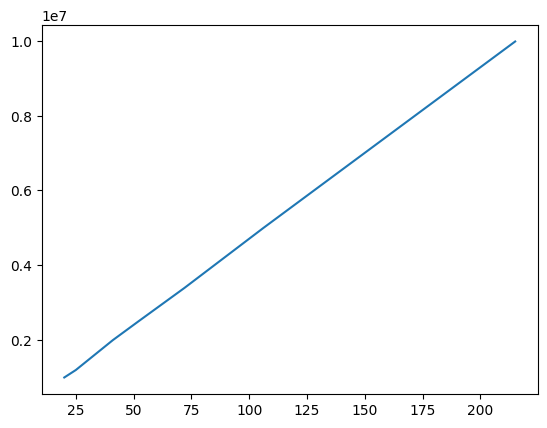

In [29]:
x = [997920, 1197504, 1297296, 1496880, 1696464, 1995840, 2494800, 3392928, 4989600, 9979200]
y = [20, 25, 27, 31, 35, 41, 52, 72, 106, 180+35]
plt.plot(y, x)

In [178]:
list(range(10, 1, -1))

[10, 9, 8, 7, 6, 5, 4, 3, 2]

In [20]:
columns = numeric.keys()
types = {key: type(value[0]) for key, value in numeric.items()}
generated = pd.DataFrame(data=df_raw, columns=columns)
generated = generated.astype(types)
generated.head()

,Age,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked
0,0,0.0,3,0,1,0,8,2
1,0,0.0,3,0,1,0,8,0
2,0,0.0,3,0,1,0,8,1
3,0,0.0,3,0,1,0,8,3
4,0,0.0,3,0,1,0,2,2


In [21]:
generated.Age.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [22]:
generated.count()

Age         9979200
Fare        9979200
Pclass      9979200
Sex         9979200
SibSp       9979200
Parch       9979200
Cabin       9979200
Embarked    9979200
dtype: int64

In [24]:
generated.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9979200 entries, 0 to 9979199
Columns: 8 entries, Age to Embarked
dtypes: float64(1), int32(4), int64(3)
memory usage: 456.8 MB


In [ ]:
    cols, indexes = top5_find_by_importance(explainer, data_copy)

    res_vals, col_vals = top5_centered_importance(explainer, data_copy, col_name)


In [26]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(generated.copy())
col_names = []
indexes = []
mean_importance = list(np.mean(np.absolute(shap_values), axis=0))
max_list = sorted(mean_importance)[-5:]
for max_val in max_list:
    indexes.append(mean_importance.index(max_val))
    col_names.append(generated.columns[mean_importance.index(max_val)])

In [46]:
df = generated.copy()

In [54]:
i = 0
for col in df.columns:
    df[f'{col}_imp'] = shap_values[:, i]
    i += 1

In [55]:
df

,Age,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_imp,Fare_imp,Pclass_imp,Sex_imp,SibSp_imp,Parch_imp,Cabin_imp,Embarked_imp
0,0,0.0000,3,0,1,0,8,2,0.420696,-0.763060,3.695189,0.806548,0.106178,-1.754545,0.013883,-0.024218
1,0,0.0000,3,0,1,0,8,0,0.398679,-0.736817,3.707690,0.800110,0.108225,-2.021857,-0.108471,0.540706
2,0,0.0000,3,0,1,0,8,1,0.405689,-0.773641,3.789224,0.806119,0.098602,-2.142056,0.011811,-0.285514
3,0,0.0000,3,0,1,0,8,3,0.420696,-0.763060,3.695189,0.806548,0.106178,-1.754545,0.013883,-0.024218
4,0,0.0000,3,0,1,0,2,2,0.370713,-0.744991,2.805331,0.774834,0.098831,-2.066766,-1.010673,-0.158700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979195,99,512.3292,2,1,5,6,5,3,-0.782420,0.569560,1.290716,0.140581,-0.284586,-1.198655,0.053060,-0.084048
9979196,99,512.3292,2,1,5,6,7,2,-0.781335,0.545396,1.334466,0.141142,-0.283658,-1.058557,0.002762,-0.038004
9979197,99,512.3292,2,1,5,6,7,0,-0.739091,0.555135,1.497834,0.141403,-0.262675,-1.585974,-0.064732,0.562602
9979198,99,512.3292,2,1,5,6,7,1,-0.744387,0.609449,1.419623,0.168310,-0.283839,-1.702721,0.000691,-0.167970


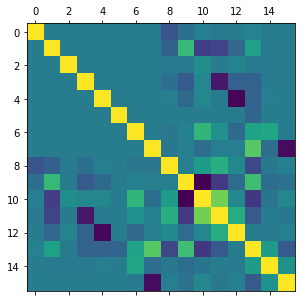

In [57]:
plt.matshow(df.corr())
plt.show()

In [68]:
grouped = df.groupby("Age", axis=0)

In [85]:
grouped.describe()

Fare                                                            \
       count      mean        std  min        25%       50%        75%   
Age                                                                      
0    99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
1    99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
2    99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
3    99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
4    99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
..       ...       ...        ...  ...        ...       ...        ...   
95   99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
96   99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
97   99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
98   99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   
99   99792.0  256.1646  162.01353  0.0  102.46584  256.1646  409.86336   

                Pclass       ... Cabin_imp           Embarked_imp            \
          max    count mean  ...       75%       max        count      mean   
Age                          ...                                              
0    512.3292  99792.0  2.0  ...  0.166245  1.415961      99792.0  0.065914   
1    512.3292  99792.0  2.0  ...  0.166245  1.415961      99792.0  0.065914   
2    512.3292  99792.0  2.0  ...  0.165255  1.414971      99792.0  0.076686   
3    512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   
4    512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   
..        ...      ...  ...  ...       ...       ...          ...       ...   
95   512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   
96   512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   
97   512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   
98   512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   
99   512.3292  99792.0  2.0  ...  0.123495  1.405511      99792.0  0.086925   

                                                                 
          std       min       25%       50%       75%       max  
Age                                                              
0    0.383027 -0.426522 -0.182361 -0.078378  0.110711  0.997595  
1    0.383027 -0.426522 -0.182361 -0.078378  0.110711  0.997595  
2    0.375766 -0.408962 -0.166122 -0.064069  0.122509  0.983070  
3    0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  
4    0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  
..        ...       ...       ...       ...       ...       ...  
95   0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  
96   0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  
97   0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  
98   0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  
99   0.398651 -0.392770 -0.161253 -0.095363  0.120978  1.012388  

[100 rows x 120 columns]

In [106]:
df[df['Age']==23][['Sex_imp']].describe()

,Sex_imp
count,99792.000000
mean,0.302742
std,0.208090
min,0.032016
25%,0.133871
50%,0.358354
75%,0.421715
max,0.878685


In [116]:
grouped_sex = df[df['Age']==23][['Sex_imp']].groupby("Sex_imp", axis=0)

In [ ]:
res = {}
for x, y in grouped_sex.groups.items():
    print(x, len(y))
    if len(y) > 200:
        res[x] = len(y)


In [134]:
res

{0.03201553598046303: 840,
 0.03835226967930794: 1680,
 0.048371244221925735: 210,
 0.0540972463786602: 840,
 0.054707977920770645: 420,
 0.0575481615960598: 2520,
 0.060433994978666306: 1680,
 0.0638849064707756: 5040,
 0.06552012264728546: 840,
 0.0704529657959938: 210,
 0.0739038810133934: 630,
 0.07483377307653427: 210,
 0.07678971439599991: 420,
 0.0802406296133995: 1260,
 0.08187583833932877: 210,
 0.08760183304548264: 840,
 0.09105274826288223: 2520,
 0.09691547602415085: 210,
 0.10036639124155045: 630,
 0.10395754128694534: 210,
 0.10486464947462082: 420,
 0.10740845650434494: 630,
 0.10833834856748581: 210,
 0.126946359872818: 420,
 0.1303972750902176: 1260,
 0.13042005896568298: 210,
 0.1338709592819214: 630,
 0.13424378633499146: 840,
 0.14058052003383636: 1680,
 0.14114218950271606: 5040,
 0.1414027214050293: 2520,
 0.15059949457645416: 210,
 0.15693624317646027: 420,
 0.15749789774417877: 1260,
 0.157758429646492: 630,
 0.167748361825943: 840,
 0.1683100163936615: 2520,
 0

In [114]:
df[df['Age']==23]['Sex_imp'].unique()

array([0.81501985, 0.807265  , 0.81327343, 0.7833057 , 0.7878363 ,
       0.7815593 , 0.75201195, 0.75654256, 0.75026554, 0.74659556,
       0.75112617, 0.74484915, 0.81537557, 0.8199062 , 0.8136291 ,
       0.7969634 , 0.7909221 , 0.79693055, 0.7652492 , 0.77149343,
       0.7652164 , 0.73395544, 0.7401997 , 0.73392266, 0.72853905,
       0.7347833 , 0.72850627, 0.79731905, 0.8035633 , 0.7972862 ,
       0.8182281 , 0.81047326, 0.8164817 , 0.786514  , 0.7910446 ,
       0.78476757, 0.75522023, 0.75975084, 0.7534738 , 0.74980384,
       0.75433445, 0.7480574 , 0.81858385, 0.82311445, 0.8168374 ,
       0.856329  , 0.8169218 , 0.85922676, 0.75622445, 0.681335  ,
       0.75912225, 0.7736478 , 0.6987583 , 0.7765456 , 0.78175706,
       0.7068676 , 0.78465486, 0.8549594 , 0.7800699 , 0.85785717,
       0.8778865 , 0.8363797 , 0.8786847 , 0.77778196, 0.7007928 ,
       0.7785801 , 0.7952053 , 0.7182161 , 0.79600346, 0.80331457,
       0.7263254 , 0.80411273, 0.8765169 , 0.7995278 , 0.87731

In [92]:
print(shap_values[:, 2])

[3.6951895 3.7076902 3.7892237 ... 1.4978341 1.4196235 1.3344656]


In [90]:
grouped.mean().head(50)

,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_imp,Fare_imp,Pclass_imp,Sex_imp,SibSp_imp,Parch_imp,Cabin_imp,Embarked_imp
Age,,,,,,,,,,,,,,,
0,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,1.026710,1.250064,0.843890,0.342086,-0.162407,-1.616896,0.013324,0.065914
1,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,1.026710,1.250064,0.843890,0.342086,-0.162407,-1.616896,0.013324,0.065914
2,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,0.993500,1.250064,0.859432,0.341956,-0.161329,-1.611428,0.024289,0.076686
3,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.674899,0.585389,1.155444,0.302742,-0.141805,-1.261531,0.016674,0.086925
4,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.674899,0.585389,1.155444,0.302742,-0.141805,-1.261531,0.016674,0.086925
5,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.674899,0.585389,1.155444,0.302742,-0.141805,-1.261531,0.016674,0.086925
6,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.674899,0.585389,1.155444,0.302742,-0.141805,-1.261531,0.016674,0.086925
7,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.674899,0.585389,1.155444,0.302742,-0.141805,-1.261531,0.016674,0.086925
8,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.674899,0.585389,1.155444,0.302742,-0.141805,-1.261531,0.016674,0.086925


In [77]:
grouped.median()

,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_imp,Fare_imp,Pclass_imp,Sex_imp,SibSp_imp,Parch_imp,Cabin_imp,Embarked_imp
Age,,,,,,,,,,,,,,,
0,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,1.086293,1.431484,0.636896,0.323648,-0.216592,-1.592462,0.051844,-0.078378
1,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,1.086293,1.431484,0.636896,0.323648,-0.216592,-1.592462,0.051844,-0.078378
2,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,1.051900,1.431484,0.654526,0.323867,-0.214849,-1.589245,0.048102,-0.064069
3,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.701190,0.641137,0.963843,0.358354,-0.180122,-1.243016,-0.002592,-0.095363
4,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.701190,0.641137,0.963843,0.358354,-0.180122,-1.243016,-0.002592,-0.095363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.701190,0.641137,0.963843,0.358354,-0.180122,-1.243016,-0.002592,-0.095363
96,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.701190,0.641137,0.963843,0.358354,-0.180122,-1.243016,-0.002592,-0.095363
97,256.1646,2.0,0.5,2.5,3.0,4.0,1.5,-0.701190,0.641137,0.963843,0.358354,-0.180122,-1.243016,-0.002592,-0.095363


In [78]:
grouped.min()

,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_imp,Fare_imp,Pclass_imp,Sex_imp,SibSp_imp,Parch_imp,Cabin_imp,Embarked_imp
Age,,,,,,,,,,,,,,,
0,0.0,1,0,0,0,0,0,0.350804,-0.850910,-0.191264,0.150022,-0.339362,-2.975204,-1.120165,-0.426522
1,0.0,1,0,0,0,0,0,0.350804,-0.850910,-0.191264,0.150022,-0.339362,-2.975204,-1.120165,-0.426522
2,0.0,1,0,0,0,0,0,0.335089,-0.850910,-0.172133,0.149460,-0.337618,-2.962228,-1.085261,-0.408962
3,0.0,1,0,0,0,0,0,-0.800612,-0.495118,0.154508,0.032016,-0.312179,-2.858494,-1.032428,-0.392770
4,0.0,1,0,0,0,0,0,-0.800612,-0.495118,0.154508,0.032016,-0.312179,-2.858494,-1.032428,-0.392770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,1,0,0,0,0,0,-0.800612,-0.495118,0.154508,0.032016,-0.312179,-2.858494,-1.032428,-0.392770
96,0.0,1,0,0,0,0,0,-0.800612,-0.495118,0.154508,0.032016,-0.312179,-2.858494,-1.032428,-0.392770
97,0.0,1,0,0,0,0,0,-0.800612,-0.495118,0.154508,0.032016,-0.312179,-2.858494,-1.032428,-0.392770


In [76]:
grouped.max()

,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_imp,Fare_imp,Pclass_imp,Sex_imp,SibSp_imp,Parch_imp,Cabin_imp,Embarked_imp
Age,,,,,,,,,,,,,,,
0,512.3292,3,1,5,6,8,3,1.236288,1.773888,4.128839,0.892450,0.109097,-0.823929,1.415961,0.997595
1,512.3292,3,1,5,6,8,3,1.236288,1.773888,4.128839,0.892450,0.109097,-0.823929,1.415961,0.997595
2,512.3292,3,1,5,6,8,3,1.187937,1.773888,4.146469,0.891887,0.108843,-0.810567,1.414971,0.983070
3,512.3292,3,1,5,6,8,3,-0.246860,1.019812,4.207376,0.878685,0.115032,-0.145907,1.405511,1.012388
4,512.3292,3,1,5,6,8,3,-0.246860,1.019812,4.207376,0.878685,0.115032,-0.145907,1.405511,1.012388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,512.3292,3,1,5,6,8,3,-0.246860,1.019812,4.207376,0.878685,0.115032,-0.145907,1.405511,1.012388
96,512.3292,3,1,5,6,8,3,-0.246860,1.019812,4.207376,0.878685,0.115032,-0.145907,1.405511,1.012388
97,512.3292,3,1,5,6,8,3,-0.246860,1.019812,4.207376,0.878685,0.115032,-0.145907,1.405511,1.012388


In [74]:
grouped.head()

,Age,Fare,Pclass,Sex,SibSp,Parch,Cabin,Embarked,Age_imp,Fare_imp,Pclass_imp,Sex_imp,SibSp_imp,Parch_imp,Cabin_imp,Embarked_imp
0,0,0.0,3,0,1,0,8,2,0.420696,-0.763060,3.695189,0.806548,0.106178,-1.754545,0.013883,-0.024218
1,0,0.0,3,0,1,0,8,0,0.398679,-0.736817,3.707690,0.800110,0.108225,-2.021857,-0.108471,0.540706
2,0,0.0,3,0,1,0,8,1,0.405689,-0.773641,3.789224,0.806119,0.098602,-2.142056,0.011811,-0.285514
3,0,0.0,3,0,1,0,8,3,0.420696,-0.763060,3.695189,0.806548,0.106178,-1.754545,0.013883,-0.024218
4,0,0.0,3,0,1,0,2,2,0.370713,-0.744991,2.805331,0.774834,0.098831,-2.066766,-1.010673,-0.158700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879408,99,0.0,3,0,1,0,8,2,-0.273745,-0.404497,3.770360,0.815020,0.114160,-1.582914,0.006465,-0.023592
9879409,99,0.0,3,0,1,0,8,0,-0.255440,-0.390426,3.777941,0.807265,0.113767,-1.925580,-0.111190,0.581653
9879410,99,0.0,3,0,1,0,8,1,-0.262094,-0.425943,3.866649,0.813273,0.104144,-2.011373,0.004393,-0.258231
9879411,99,0.0,3,0,1,0,8,3,-0.273745,-0.404497,3.770360,0.815020,0.114160,-1.582914,0.006465,-0.023592


In [66]:
res.

Age
0     1.026710
1     1.026710
2     0.993500
3    -0.674899
4    -0.674899
        ...   
95   -0.674899
96   -0.674899
97   -0.674899
98   -0.674899
99   -0.674899
Name: Age_imp, Length: 100, dtype: float32

In [ ]:
old = datetime.datetime.now()
data = generated.copy()
coll_name = 'Age'
min_max = getMinMax(df)
cond1 = data[coll_name] >= min_max[coll_name][0]
cond2 = data[coll_name] <= min_max[coll_name][1]
colors = ["brown", "teal", "blue", "coral", "limegreen"]
plot_top5_centered_importance(clf, data, coll_name, True)
new = datetime.datetime.now()

In [ ]:
new - old2

In [181]:
import datetime
old = datetime.datetime.now()


datetime.timedelta(0)

<AxesSubplot:title={'center':'Центрированный график изменения абсолютной важности переменных'}, xlabel='Age', ylabel='Важность переменных'>

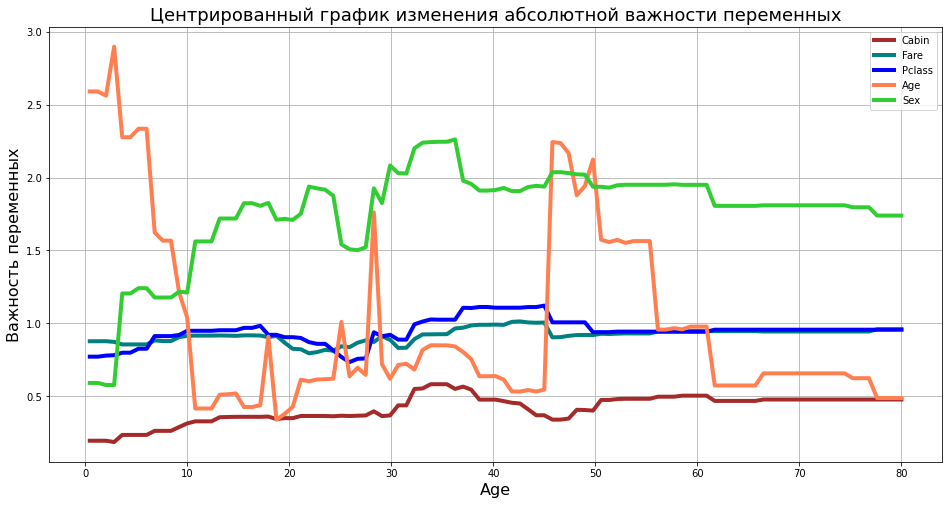

In [61]:
data = df.copy()
coll_name = 'Age'
min_max = getMinMax(df)
cond1 = data[coll_name] >= min_max[coll_name][0]
cond2 = data[coll_name] <= min_max[coll_name][1]
colors = ["brown", "teal", "blue", "coral", "limegreen"]
plot_top5_centered_importance(clf, data, coll_name, True)

In [4]:
def plot_top5_centered_importance(model, data, col_name, absolute=False):
    plot = plt.axes()
    plot.figure.set_size_inches(16, 8)

    if absolute:
        title = "Центрированный график изменения абсолютной важности переменных"
    else:
        title = "Центрированный график изменения важности переменных"
    plot.set_title(title, fontsize=18)

    explainer = shap.TreeExplainer(model)

    data_copy = data.copy()
    if "y" in data.columns:
        data_copy = data_copy.drop("y", axis=1)

    cols, indexes = top5_find_by_importance(explainer, data_copy)

    res_vals, col_vals = top5_centered_importance(explainer, data_copy, col_name)

    res_vals = np.array(res_vals)

    for i in range(0, len(indexes)):
        res = []

        for j in range(0, len(res_vals)):
            val = res_vals[j, :, indexes[i]]
            if absolute:
                val = np.absolute(val)
            res.append(val.mean())

        plot.plot(col_vals, res, color=colors[i], linewidth=4, label=cols[i])

    plot.grid()
    plot.set_xlabel(col_name, fontsize=16)
    plot.set_ylabel("Важность переменных", fontsize=16)
    plot.legend()

    return plot

In [5]:
def getMinMax(data):
    data_copy = data.copy()
    if "y" in data.columns:
        data_copy = data_copy.drop("y", axis=1)
    ar = np.array(data_copy)
    min_values = np.amin(ar, axis=0)
    max_values = np.amax(ar, axis=0)
    return {key: (v1, v2) for v1, v2, key in zip(min_values, max_values, data.columns)}

In [6]:
def create_variable_list(col):
    min_val = col.min()
    max_val = col.max()

    unique = col.unique()

    if len(unique) < 50:
        col_vals = sorted(list(unique))
    else:
        delta = (max_val - min_val) / 100
        col_vals = []
        while min_val <= max_val:
            col_vals.append(min_val)
            min_val += delta
    return col_vals

In [7]:
def top5_centered_importance(explainer, data, col_name):
    data_copy = data.copy()

    col_vals = create_variable_list(data[col_name])
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col
        shap_values = explainer(data_copy).values
        res_vals.append(shap_values)

    return res_vals, col_vals

In [8]:
def top5_find_by_importance(explainer, data):
    shap_values = explainer.shap_values(data)

    col_names = []
    indexes = []
    mean_importance = list(np.mean(np.absolute(shap_values), axis=0))

    max_list = sorted(mean_importance)[-5:]
    for max_val in max_list:
        indexes.append(mean_importance.index(max_val))
        col_names.append(data.columns[mean_importance.index(max_val)])

    return col_names, indexes

In [9]:
def ice_plot_data_y(model, data, col_name):
    data_copy = data.copy()
    if "y" in data.columns:
        data_copy = data_copy.drop("y", axis=1)

    col_vals = create_variable_list(data[col_name])
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col
        predict = model.predict_proba(data_copy)[:, 1]
        res_vals.append(predict)

    return res_vals, col_vals

In [10]:
def create_variable_list(col):
    min_val = col.min()
    max_val = col.max()

    unique = col.unique()

    if len(unique) < 50:
        col_vals = sorted(list(unique))
    else:
        delta = (max_val - min_val) / 100
        col_vals = []
        while min_val <= max_val:
            col_vals.append(min_val)
            min_val += delta
    return col_vals


In [11]:
def ice_plot_data_importance(explainer, data, col_name):
    data_copy = data.copy()
    if "y" in data.columns:
        data_copy = data_copy.drop("y", axis=1)

    col_vals = create_variable_list(data[col_name])
    res_vals = []

    for val in col_vals:
        new_col = len(data_copy[col_name]) * [val]
        data_copy[col_name] = new_col

        shap_values = np.array(explainer(data_copy).values)

        res_vals.append(shap_values[:, list(data.columns).index(col_name)])

    return res_vals, col_vals

In [12]:
def plot_ice_plot(model, data, col_name, importance=False):
    plot = plt.axes()

    if importance:
        explainer = shap.TreeExplainer(model)
        res_vals, col_vals = ice_plot_data_importance(explainer, data, col_name)
        y_label = f"Важность переменной {col_name}"
        title = f"с-ICE график изменения важности переменной {col_name}"
    else:
        res_vals, col_vals = ice_plot_data_y(model, data, col_name)
        y_label = "Вероятность удачного исхода"
        title = f"с-ICE график вероятности удачного исхода при изменении переменной {col_name}"

    df = pd.DataFrame(np.array(res_vals))
    df = df.T
    mean = df.mean()

    plot.figure.set_size_inches(16, 8)
    plot.set_title(title, fontsize=18)

    for i in df.index:
        plot.plot(col_vals, df.loc[i], color="black", linewidth=0.1)

    plot.plot(col_vals, mean, color="lime", linewidth=6)

    plot.grid()
    plot.set_xlabel(col_name, fontsize=16)
    plot.set_ylabel(y_label, fontsize=16)

    return plot


In [13]:
def find_category_columns(data):
    data_copy = data.copy()
    if "y" in data.columns:
        data_copy = data_copy.drop("y", axis=1)
    categorical = []

    for col in data_copy.columns:
        if len(data_copy[col].unique()) < 10:
            categorical.append(col)
    return categorical
